In [67]:
import random
import os
import urllib3
import pandas as pd
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

from madison_coordinates import madisonCoordinateToLatLon
import data_retreiver
print(dir(data_retreiver))

['DATASETS', 'DATA_PATH', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'download_datasets', 'download_file', 'load_csv_datasets', 'os', 'pd', 'urllib3']


In [58]:
(raw, names) = data_retreiver.load_csv_datasets("all_parcel_raw", "all_parcel_names")
raw["Parcel"] = raw["Parcel"].astype("str")
print(raw.dtypes)
raw.set_index("Parcel", inplace = True)

raw

OBJECTID                 int64
Parcel                  object
XRefParcel               int64
Address                 object
DateParcelChanged       object
                        ...   
MaxConstructionYear      int64
XCoord                 float64
YCoord                 float64
SHAPESTArea            float64
SHAPESTLength          float64
Length: 143, dtype: object


,OBJECTID,XRefParcel,Address,DateParcelChanged,PropertyClass,PropertyUse,AssessmentArea,AreaName,MoreThanOneBuild,HomeStyle,...,StreetID,StormOutfall,FireDemandZone,FireDemandSubZone,PropertyChangeDate,MaxConstructionYear,XCoord,YCoord,SHAPESTArea,SHAPESTLength
Parcel,,,,,,,,,,,,,,,,,,,,,
71002107665,1,71002104033,121 Metro Ter Unit 109,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107673,2,71002104033,121 Metro Ter Unit 201,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107681,3,71002104033,121 Metro Ter Unit 202,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107699,4,71002104033,121 Metro Ter Unit 203,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107706,5,71002104033,121 Metro Ter Unit 204,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71002107615,80162,71002104033,121 Metro Ter Unit 104,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107623,80163,71002104033,121 Metro Ter Unit 105,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604
71002107631,80164,71002104033,121 Metro Ter Unit 106,2020/06/03 00:00:00+00,Residential,Condominium,5115,Condominiums in Area 115,NaN,Garden,...,5686,NaN,0,0,1970/01/01 00:00:00+00,2006,851889.99203,492200.302163,189753.7883,1842.05604


In [59]:
filt_vector = raw["PropertyUse"] == "0 unit Apartment"
raw[filt_vector]

,OBJECTID,XRefParcel,Address,DateParcelChanged,PropertyClass,PropertyUse,AssessmentArea,AreaName,MoreThanOneBuild,HomeStyle,...,StreetID,StormOutfall,FireDemandZone,FireDemandSubZone,PropertyChangeDate,MaxConstructionYear,XCoord,YCoord,SHAPESTArea,SHAPESTLength
Parcel,,,,,,,,,,,,,,,,,,,,,
81030302187,27884,81030302187,2838 Dryden Dr,2020/06/15 00:00:00+00,Commercial,0 unit Apartment,9912,No Area Name Given,NaN,NaN,...,2372,ME06A375,0,0,1970/01/01 00:00:00+00,1980,827611.076926,502316.213718,22675.750336,587.375362


In [60]:
print(type(madisonCoordinateToLatLon(843672.64965079, 487138.73206368)))

<class 'tuple'>


In [65]:
raw_subset = raw.iloc[:]
locations = [] #dict parcel_id -> lat = {} #dict parcel_id -> lon
for parcelId, contents in raw_subset.iterrows():
    record = {}
    
    mad_x = contents.XCoord
    mad_y = contents.YCoord

    (lat, lon) = madisonCoordinateToLatLon(mad_x, mad_y)
    record["Parcel"] = parcelId
    record["Latitude"] = lat
    record["Longitude"] = lon

    locations.append(record)

locations

9497068170285},
 {'Parcel': '71003106244',
  'Latitude': 43.10099864530305,
  'Longitude': -89.29524504250307},
 {'Parcel': '71003106252',
  'Latitude': 43.100658888141744,
  'Longitude': -89.29502223864007},
 {'Parcel': '71003106260',
  'Latitude': 43.100492666062244,
  'Longitude': -89.29522620918306},
 {'Parcel': '71003106278',
  'Latitude': 43.10048408079443,
  'Longitude': -89.29561882089546},
 {'Parcel': '71003106286',
  'Latitude': 43.10055984995742,
  'Longitude': -89.29592708211693},
 {'Parcel': '71003106294',
  'Latitude': 43.100827235041145,
  'Longitude': -89.29592324077707},
 {'Parcel': '71003106301',
  'Latitude': 43.10104341114858,
  'Longitude': -89.29588690550719},
 {'Parcel': '71003107010',
  'Latitude': 43.10146991135206,
  'Longitude': -89.29597822766127},
 {'Parcel': '71003107028',
  'Latitude': 43.10147669159825,
  'Longitude': -89.2956614931767},
 {'Parcel': '71003107036',
  'Latitude': 43.1014831375789,
  'Longitude': -89.29535620411497},
 {'Parcel': '7100310704

In [66]:
locationsDF = pd.DataFrame(columns=["Parcel", "Latitude", "Longitude"])
#
# locationsDF["Parcel"] = locationsDF["Parcel"].astype("object")
print(locationsDF.dtypes)
for locationRecord in locations:
    locationsDF = locationsDF.append(locationRecord, ignore_index=True)
locationsDF


Parcel       object
Latitude     object
Longitude    object
dtype: object


,Parcel,Latitude,Longitude
0,71002107665,43.100414,-89.268753
1,71002107673,43.100414,-89.268753
2,71002107681,43.100414,-89.268753
3,71002107699,43.100414,-89.268753
4,71002107706,43.100414,-89.268753
...,...,...,...
80161,71002107615,43.100414,-89.268753
80162,71002107623,43.100414,-89.268753
80163,71002107631,43.100414,-89.268753
80164,71002107649,43.100414,-89.268753


(array([ 309.,  863.,  537.,  687.,  640.,  846.,  840., 1029., 2433.,
        2569., 2091., 1625., 2101., 1903., 2613., 1876., 2326., 1958.,
        2862., 3724., 4467., 5520., 4220., 3281., 2151., 2626., 2723.,
        2454., 2362., 1632.,  672., 1022.,  992.,  987.,  949.,  699.,
         746.,  433., 1355.,  942.,  926., 1266., 1332., 1841.,  299.,
         140.,   93.,  153.,   39.,   12.]),
 array([42.99965252, 43.00308113, 43.00650973, 43.00993834, 43.01336695,
        43.01679555, 43.02022416, 43.02365277, 43.02708137, 43.03050998,
        43.03393859, 43.03736719, 43.0407958 , 43.04422441, 43.04765301,
        43.05108162, 43.05451023, 43.05793883, 43.06136744, 43.06479605,
        43.06822465, 43.07165326, 43.07508187, 43.07851047, 43.08193908,
        43.08536769, 43.08879629, 43.0922249 , 43.0956535 , 43.09908211,
        43.10251072, 43.10593932, 43.10936793, 43.11279654, 43.11622514,
        43.11965375, 43.12308236, 43.12651096, 43.12993957, 43.13336818,
        43.13679

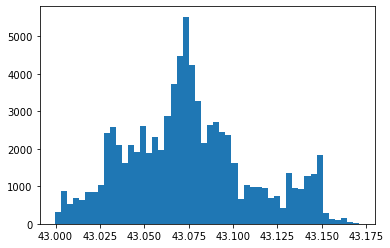

In [71]:
fig, ax = plt.subplots()
ax.hist(locationsDF["Latitude"], bins = 50)

In [72]:
locationsDF.to_csv('all_parcel_locations.csv', index=False)

In [73]:
raw.loc["70915302015"]

OBJECTID                                58244
XRefParcel                        70915302015
Address                   2000 Observatory Dr
DateParcelChanged      2018/10/26 00:00:00+00
PropertyClass                     Residential
                                ...          
MaxConstructionYear                         0
XCoord                                 811963
YCoord                                 483949
SHAPESTArea                       1.13186e+06
SHAPESTLength                         6194.94
Name: 70915302015, Length: 142, dtype: object